In [89]:
import numpy as np
import escnn.gspaces as gspaces
import escnn.nn as enn
import escnn
import torch
import torch.nn as nn

import math
import time
import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm
from scipy import sparse
import seaborn as sns
from sympy.combinatorics import Permutation, PermutationGroup

import netket as nk
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

PATH = os.getcwd()

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.set_default_device(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0),1), 'B')
    print('Reserved: ', round(torch.cuda.memory_reserved(0),1), 'B')
    print()
    torch.set_default_device('cuda')

# test
T = torch.randn(1, 4).to(device)
print(T)
print('Allocated:', round(torch.cuda.memory_allocated(0),1), 'B')

Using device: cpu
tensor([[ 0.0272, -0.3734,  1.1515, -0.2591]])
Allocated: 0 B


### Generate Table of All Possible States Indexed in Lexigraphical Order

In [91]:
def generateStateTable(n,n0,N): # assumes ab > n0 > 0 and N = n choose n0
    states = []
    state = np.concatenate((np.ones(n-n0),-1*np.ones(n0))).astype(int)
    for i in range(0,N):
        states.append(np.copy(state))
        j = 0
        flag = True
        flip_count = 0
        up_count = 0
        while (flag): 
            if (j == n-1):
                for m in range(0,n):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                if (flip_count == 1):
                    break
            if (state[j] != 1):
                j += 1  
            elif (state[j+1] != 1):
                for m in range(0,j):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                    if (state[m] == 1):
                        up_count += 1
                if (flip_count == 1):
                    state[j],state[j+1] = state[j+1],state[j]
                    for k in range(1,up_count+1):
                        state[j-k],state[k-1] = state[k-1],state[j-k]
                else:
                    state[j],state[j+1] = state[j+1],state[j]
                flag = False
            else:
                j += 1
    return states

### Generate Adjacency Matrices

In [92]:
class Node:
    def __init__(self, position, xadj, yadj):
        self.position = position
        self.xadj = xadj
        self.yadj = yadj
    
    def __str__(self):
        return f"{self.position} {self.xadj} {self.yadj}"

In [93]:
def squareAdjacencyList(a,b): # constructs a periodic adjacency graph with width a and height b
    nodes = []
    for j in range(0,b):
        for i in range(0,a):
            xadj = [[(i-1) % a,j],[(i+1) % a,j]]
            yadj = [[i,(j-1) % b],[i,(j+1) % b]]
            nodes.append(Node([[i,j]],xadj,yadj))

    return nodes

### First Neighbors Adjacency Matrix

In [94]:
def firstneighbors(a,b): 
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False
            for xptr in nodes[i].xadj:
                if xptr in nodes[j].position:
                    flag = True
            for yptr in nodes[i].yadj:
                if yptr in nodes[j].position:
                    flag = True
            if flag:
                J[i][j] = 1
                J[j][i] = 1
        
    return np.array(J)

### Second Neighbors (Euclidean) Adjacency Matrix

In [95]:
def secondneighbors(a,b):
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False

            for xptr in nodes[i].xadj:
                try:
                    for k in range(0,N):
                        if xptr in nodes[k].position:
                            intermediate = k
                    for yptr in nodes[intermediate].yadj:
                        if yptr in nodes[j].position:
                            flag = True
                except UnboundLocalError:
                    pass

            if flag:
                J[i][j] = 1
                J[j][i] = 1

    return np.array(J)

### Model Parameters

In [96]:
a = 4 # x-range of supercell
b = 4 # y-range of supercell
N1 = firstneighbors(a,b)
N2 = secondneighbors(a,b)
n = a*b # number of sites in lattice

n0 = n // 2 # number of down spins in the string (taken as floor(n/2))
N = int(math.factorial(n)/(math.factorial(n0)*math.factorial(n-n0))) # number of states

stateTable = generateStateTable(n,n0,N)

### Define G-CNN Model

In [116]:
class D4Z2SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=1):
        
        super(D4Z2SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 90 degrees and reflections, modelled by D4
        self.r2_act = gspaces.flipRot2dOnR2(N=4)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = enn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of D4
        out_type = enn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = enn.SequentialModule(
            enn.MaskModule(in_type, a, margin=1),
            enn.R2Conv(in_type, out_type, kernel_size=4, padding=1, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of D4
        out_type = enn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=1, padding=2, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
        self.pool1 = enn.SequentialModule(
            enn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of D4
        out_type = enn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=1, padding=2, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of D4
        out_type = enn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=1, padding=2, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
        self.pool2 = enn.SequentialModule(
            enn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of D4
        out_type = enn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=1, padding=2, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of D4
        out_type = enn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=1, padding=1, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
        self.pool3 = enn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = enn.GroupPooling(out_type)
        
        # number of output channels
        c = self.gpool.out_type.size
        
        # Fully Connected
        self.fully_net = nn.Sequential(
            nn.Linear(c, 4096),
            nn.BatchNorm1d(4096),
            nn.ELU(inplace=True),
            nn.Linear(4096, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = enn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

### Build Model

In [117]:
model = D4Z2SteerableCNN().to(device)

### Build Data Set

In [111]:
dataset = []
for i in range(N):
    state = []
    for j in range(b):
        row = []
        for k in range(a):
            row.append(stateTable[i][4*j+k])
        state.append(row)
    dataset.append([state])

dataset = np.array(dataset).astype(np.int8)

In [118]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import InterpolationMode

import numpy as np

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'


### Test Model

In [119]:
totensor = ToTensor()
x = totensor(next(iter(dataset))).reshape(1,1,a,b)
print(x.shape)
y = model(x)
print(y)

torch.Size([1, 1, 4, 4])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4096 and 64x4096)

In [ ]:
totensor = ToTensor()
def test_model(model: torch.nn.Module, x: Image):
    np.set_printoptions(linewidth=10000)
    
    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()
    
    print()
    with torch.no_grad():
        for r in range(128):
            x_transformed = totensor(x)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()
            
            angle = r * 45
            print("{:5d} : {}".format(angle, y))
    print()

x = next(iter(dataset))

# evaluate the model
test_model(model, x)

AssertionError: (torch.Size([1, 4, 4]), 2)

### Reduce Fock Space

In [ ]:
def stateValBin(state):
    sum = 0
    for i in range(len(state)):
        if state[i] == 1:
            sum += 2**i
    return sum

def searchState(state):
    high = N-1
    low = 0
    while True:
        mid = math.floor((high+low)/2)
        if np.array_equal(state,stateTable[mid]):
            return mid
        elif stateValBin(state) > stateValBin(stateTable[mid]):
            low = mid+1
        else:
            high = mid-1

In [ ]:
def transSym(state,x,y): # translation vector (x,y)
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (i-x) % a
            jj = (j-y) % b 
            newState.append(state[a*jj+ii])
    return np.array(newState)

def spinFlipSym(state):
    return -1*state

def rotSiteSym(state,n): # rotate about the origin by n\pi/2 radians CCW
    newState = []
    if n % 4 == 0:
        return state
    elif n % 4 == 1:
        for j in range(b):
            for i in range(a):
                ii = j % a
                jj = (-i) % b
                newState.append(state[a*jj+ii])
    elif n % 4 == 2:
        for j in range(b):
            for i in range(a):
                ii = (-i) % a
                jj = (-j) % b
                newState.append(state[a*jj+ii])
    else:
        for j in range(b):
            for i in range(a):
                ii = (-j) % a
                jj = i % b
                newState.append(state[a*jj+ii])

    return np.array(newState)

def rotCentSym(state,n): # rotate about the center of the primitive cell [0-1]x[0-1] by n\pi/2 radians CCW 
    newState = []
    if n % 4 == 0:
        return state
    elif n % 4 == 1:
        for j in range(b):
            for i in range(a):
                ii = (j-0.5) % a 
                jj = (-i+0.5) % b
                ii = (ii+0.5) % a
                jj = (jj+0.5) % b
                newState.append(state[int(a*jj+ii)])
    elif n % 4 == 2:
        for j in range(b):
            for i in range(a):
                ii = (-i+0.5) % a
                jj = (-j+0.5) % b
                ii = (ii+0.5) % a
                jj = (jj+0.5) % b
                newState.append(state[int(a*jj+ii)])
    else:
        for j in range(b):
            for i in range(a):
                ii = (-j+0.5) % a 
                jj = (i-0.5) % b
                ii = (ii+0.5) % a
                jj = (jj+0.5) % b
                newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def rotHorEdgeSym(state): # rotate about the center of the edge connecting (0,0) with (1,0) by \pi radians

    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-i+0.5) % a
            jj = (-j) % b
            ii = (ii+0.5) % a
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def rotVertEdgeSym(state): # rotate about the center of the edge connecting (0,0) with (0,1) by \pi radians
    newState = []
    for j in range(b):
        for i in range(a):
            jj = (-j+0.5) % b
            ii = (-i) % a
            jj = (jj+0.5) % b
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def refVertSym(state): # reflect about the line x = 0
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-i) % a
            jj = j
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def refHorSym(state): # reflect about the line y = 0
    newState = []
    for j in range(b):
        for i in range(a):
            ii = i
            jj = (-j) % b
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def refVertCentSym(state): # reflect about the line x = 0.5
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-i+0.5) % a
            jj = j
            ii = (ii+0.5) % a
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def refHorCentSym(state): # reflect about the line y = 0.5
    newState = []
    for j in range(b):
        for i in range(a):
            ii = i
            jj = (-j+0.5) % b
            jj = (jj+0.5) % b
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def refDiagSym(state): # reflect about the line y = x
    newState = []
    for j in range(b):
        for i in range(a):
            ii = j
            jj = i
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

def refOffDiagSym(state): # reflect about the line y = -x
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-j) % a
            jj = (-i) % b
            newState.append(state[int(a*jj+ii)])
    return np.array(newState)

### Generate Symmetry Group

In [ ]:
identity = np.arange(n)
isSquare = (a == b)

gen = []

gen.append(transSym(identity,1,0))
gen.append(transSym(identity,0,1))

if isSquare:
    gen.append(rotSiteSym(identity,1))
    gen.append(rotCentSym(identity,1))
    gen.append(rotHorEdgeSym(identity))
    
    gen.append(refVertSym(identity))
    gen.append(refVertCentSym(identity))
    gen.append(refDiagSym(identity))
else:
    gen.append(rotSiteSym(identity,2))
    gen.append(rotCentSym(identity,2))
    gen.append(rotHorEdgeSym(identity))
    gen.append(rotVertEdgeSym(identity))

    gen.append(refVertSym(identity))
    gen.append(refVertCentSym(identity))
    gen.append(refHorSym(identity))
    gen.append(refHorCentSym(identity))

print(gen)

G = PermutationGroup(gen)
G.order()

[array([ 3,  0,  1,  2,  7,  4,  5,  6, 11,  8,  9, 10, 15, 12, 13, 14]), array([12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 0, 12,  8,  4,  1, 13,  9,  5,  2, 14, 10,  6,  3, 15, 11,  7]), array([ 4,  0, 12,  8,  5,  1, 13,  9,  6,  2, 14, 10,  7,  3, 15, 11]), array([ 1,  0,  3,  2, 13, 12, 15, 14,  9,  8, 11, 10,  5,  4,  7,  6]), array([ 0,  3,  2,  1,  4,  7,  6,  5,  8, 11, 10,  9, 12, 15, 14, 13]), array([ 1,  0,  3,  2,  5,  4,  7,  6,  9,  8, 11, 10, 13, 12, 15, 14]), array([ 0,  4,  8, 12,  1,  5,  9, 13,  2,  6, 10, 14,  3,  7, 11, 15])]


128

### Generate All Orbits

In [ ]:
orbits = []
signs = []

def isVisited(index):
    for orbit in orbits:
        if (index,-1) in orbit or (index,1) in orbit:
            return True
    return False

flip = (a*b) % 4 == 0

ptr = 0

while ptr < N:
    orbit = []
    orbit.append((ptr,1))
    for g in G.generate():
        newState = np.array([stateTable[ptr][g(i)] for i in range(n)])
        if flip: orbit.append((searchState(newState),1))
        else: orbit.append((searchState(newState),g.signature()))
        if n % 2 == 0: 
            if flip: orbit.append((searchState(spinFlipSym(newState)),1))
            else: orbit.append((searchState(spinFlipSym(newState)),-1*g.signature()))
    orbit = list(set(orbit))
    orbits.append(orbit)
    while isVisited(ptr):
        ptr += 1

107


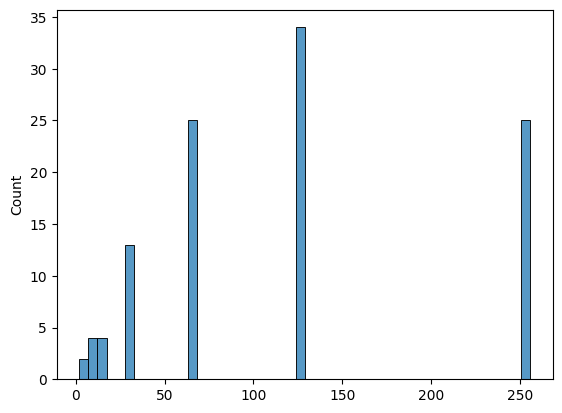

In [ ]:
orbitLengths = [len(orbits[i]) for i in range(len(orbits))]

sns.histplot(orbitLengths,bins=50)
NN = len(orbits)
print(NN)

### Compute Reduced Hamiltonian

In [ ]:
def computeHamEntry(J1,J2,i,j):
    sum = 0.0
    if (i == j):
        for k in range(0,n-1):
            for l in range(k+1,n):
                if (N1[k][l] != 0):
                    sum += J1*stateTable[i][k]*stateTable[i][l]
                if (N2[k][l] != 0):
                    sum += J2*stateTable[i][k]*stateTable[i][l]          
    else:
        tempState = np.multiply(stateTable[i],stateTable[j])
        if (np.count_nonzero(tempState == -1) == 2):
            indices = np.where(tempState == -1)
            e,f = indices[0][0],indices[0][1]
            if (N1[e][f] != 0):
                sum += 2*J1
            if (N2[e][f] != 0):
                sum += 2*J2
    
    return sum

def computeRedHam(J1,J2):
    row = []
    col = []
    data = []

    for i in range(0,NN):
        for j in range(i,NN):
            if (i == j):
                row.append(i)
                col.append(j)
                data.append(computeHamEntry(J1,J2,orbits[i][0][0],orbits[j][0][0]))
            else:
                sum = 0
                if len(orbits[i]) <= len(orbits[j]):
                    for k in orbits[i]:
                        sum += computeHamEntry(J1,J2,k[0],orbits[j][0][0])*k[1]*orbits[j][0][1]
                    sum *= len(orbits[j])
                else:
                    for k in orbits[j]:
                        sum += computeHamEntry(J1,J2,orbits[i][0][0],k[0])*orbits[i][0][1]*k[1]
                    sum *= len(orbits[i])
                sum /= np.sqrt(len(orbits[i])*len(orbits[j]))

                row.append(i)
                row.append(j)
                col.append(j)
                col.append(i)
                data.append(sum)
                data.append(sum)
    
    H = sparse.coo_array((data, (row, col)), shape=(NN,NN), dtype=np.float32)
    return H

In [ ]:
H = computeRedHam(1,0)
print(orbits)
print(H.toarray())
energies, states = sparse.linalg.eigs(H.asfptype(), k=1, which='SR')
energies = np.real(energies)
states = np.real(states)

energies,states

KeyboardInterrupt: 

In [ ]:
for i in range(min(NN,10)):
    for j in range(min(NN,10)):
        if i == j:
            break
        else:
            lsts = []
            for k in range(len(orbits[j])):
                lst = []
                sum = 0
                for l in range(len(orbits[i])):
                    sum += computeHamEntry(1,0,orbits[j][k][0],orbits[i][l][0])*orbits[j][k][1]*orbits[i][l][1]
                lsts.append(sum)
            print(lsts)

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

### Convert Back to Full Basis

In [ ]:
def toFullBasis(reducedBasisState):
    ret = np.zeros(N)
    for i in range(len(orbits)):
        for j in range(len(orbits[i])):
            ret[orbits[i][j][0]] = reducedBasisState[i]*orbits[i][j][1]/np.sqrt(len(orbits[i]))

    return ret

fullState = toFullBasis(states.T[0])

In [ ]:
H = sparse.load_npz(PATH + '/data/'+str(a)+'x'+str(b)+'hamiltonian.npz')

grdEnergy, grdState = sparse.linalg.eigs(H.asfptype(), k=1, which='SR')
grdEnergy = np.real(grdEnergy)
grdState = np.real(grdState).T[0]

In [ ]:
lattice = nk.graph.Grid(extent=[b,a], pbc=True)
hilbertSpace = nk.hilbert.Spin(s=0.5, total_sz=0.5*(n-2*n0), N=a*b)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbertSpace, graph=lattice)

netketH = hamiltonian.to_sparse().toarray()

evals = nk.exact.lanczos_ed(hamiltonian,compute_eigenvectors=True)
netState = evals[1].T[0]

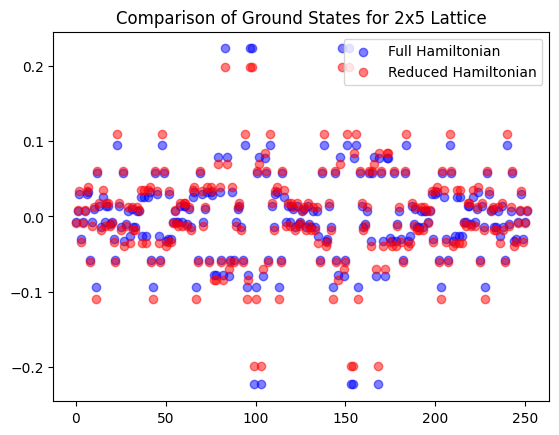

In [ ]:
fullState /= np.linalg.norm(fullState)
grdState /= np.linalg.norm(grdState)
if np.sum((grdState-fullState)**2) > np.sum((grdState+fullState)**2): fullState *= -1
if np.sum((grdState-netState)**2) > np.sum((grdState+netState)**2): netState *= -1

plt.scatter(range(N),grdState, color="blue", label="Full Hamiltonian", alpha=0.5)
plt.scatter(range(N),fullState, color="red", label="Reduced Hamiltonian", alpha=0.5)
# plt.scatter(range(N),netState, color="green", label="NetKet Hamiltonian", alpha=0.5)
plt.title("Comparison of Ground States for "+str(a)+"x"+str(b)+" Lattice")
plt.legend()
plt.show()

In [ ]:
np.sum((grdState-fullState)**2)

0.016688854464494335